In [1]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, BatchNormalization, ReLU, Add,
    Flatten, Reshape, Activation)
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np

def load_dataset(M, K, T):
    Path_Beta_mk = "D:\OneDrive - Assuit University\My_files\Master Material\Papers\P5_Joint_Powercontrol_PilotAssignement\Beta_maxmin_118957.csv"
    Path_Eitta_mk = "D:\OneDrive - Assuit University\My_files\Master Material\Papers\P5_Joint_Powercontrol_PilotAssignement\Eitta_maxmin_118957.csv"
    
    #  Load data with proper headers
    Beta_mk_T = pd.read_csv(Path_Beta_mk, header=None)
    Eitta_mk_T = pd.read_csv(Path_Eitta_mk, header=None)
    
    # Convert to numpy arrays
    Beta_mk = Beta_mk_T .values.reshape(-1, M, K)
    Eitta_mk = Eitta_mk_T .values.reshape(-1, M, K)
    Eitta_split = Eitta_mk.reshape(-1, 1, 6)
    # Verify shapes match expected dimensions
    assert Beta_mk.shape == (T, M, K), f"Beta shape mismatch. Got {Beta_mk.shape}, expected ({T}, {M}, {K})"
    return Beta_mk, Eitta_mk
    print('done 1') 

try:
    Beta_mk, Eitta_mk  = load_dataset(25, 6, 118957)
    print("Data loaded successfully!")
    print(f"Beta shape: {Beta_mk.shape}")
    #print(f"Eitta_mk shape: {Eitta_mk[0][0]}")
    #print(f"Eitta_mk split: {Eitta_split[0]}")
    
except Exception as e:
    print(f"Error loading data: {str(e)}")

Data loaded successfully!
Beta shape: (118957, 25, 6)


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
import joblib
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, ReLU, Add,
    GlobalAveragePooling2D, Dense, Reshape, Activation,MaxPooling2D
)

INPUT_SIZE = (25,6,1)
OUTPUT_SIZE = 6
EPOCHS = 200
BATCH_SIZE = 128 

def preprocess_data(Beta_mk, Eitta_mk):
    """Preprocess input and target data with correct reshaping."""
    # Input processing
    Beta_flat = Beta_mk.reshape(-1, 25*6)  # Flatten to (samples, 150)
    Beta_flat = np.where(Beta_flat <= 0, 1e-30, Beta_flat)
    Beta_log = 10 * np.log10(Beta_flat)
    scaler_X = MinMaxScaler()
    Beta = scaler_X.fit_transform(Beta_log)
    # Reshape to (samples, 25, 6, 1) for CNN input
    Beta = Beta.reshape(-1, 25, 6, 1)

    # Target processing: 
    #For the first raw = first AP , normalize each raw individually
    Eitta_vector=Eitta_mk[:,0,:]
    Eitta_vector = np.where(Eitta_vector <= 0, 1e-30, Eitta_vector)
    y_log = 10 * np.log10(Eitta_vector)
    scaler_Y = MinMaxScaler()
    Eitta = scaler_Y.fit_transform(y_log)
    #print('Eitta_mk_original matrix',Eitta_mk[:,0,:])
    #print('Eitta_normalized col' , Eitta)

    # Check Eitta_mk statistics
    #print("Eitta_mk stats:")
    #print("Min:", np.min(Eitta))
    #print("Max:", np.max(Eitta))
    #print("Unique values:", np.unique(Eitta))
    return Beta, Eitta, scaler_X, scaler_Y
# ==============================================
# Load data
Beta_mk, Eitta_mk = load_dataset(25, 6, 118957)
# Preprocess data
X, y, scaler_X, scaler_Y = preprocess_data(Beta_mk, Eitta_mk)
print('y_shape' , y.shape)
print('x_shape' , X.shape)


Eitta_mk_original matrix [[5.1871e+05 1.0354e+04 9.5617e+03 1.7740e+05 2.8184e+04 1.5366e+05]
 [1.0173e+05 2.3181e+05 2.3645e+05 8.8427e+04 1.3277e+04 2.4579e+04]
 [6.7291e+03 5.5627e+03 5.6279e+04 1.1726e+02 1.2268e+05 7.3763e+04]
 ...
 [5.0676e+04 4.9556e+04 2.2512e+06 6.8335e+04 9.0425e+05 5.9558e+07]
 [2.3591e+05 5.4038e+04 2.1575e+05 2.0902e+05 7.2909e+04 1.7470e+05]
 [9.5075e+04 6.5171e+04 6.9184e+04 5.6779e+04 1.0908e+05 2.8147e+04]]
Eitta_normalized col [[0.70075615 0.50706938 0.54802806 0.67527774 0.58131284 0.6856289 ]
 [0.62864348 0.64360234 0.69154177 0.64347651 0.54858821 0.60866179]
 [0.50841838 0.47978123 0.62732618 0.3408461  0.6452571  0.65481077]
 ...
 [0.59779484 0.57583911 0.79235488 0.63170319 0.73209977 0.93590643]
 [0.66587807 0.57964205 0.68744317 0.68276971 0.62263408 0.69101779]
 [0.62564851 0.58786979 0.63656197 0.6232414  0.64014888 0.61435389]]
Eitta_mk stats:
Min: 0.0
Max: 1.0
Unique values: [0.         0.01231077 0.01278284 ... 0.99504849 1.         1.   

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
import joblib
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, ReLU, Add,
    GlobalAveragePooling2D, Dense, Reshape, Activation,MaxPooling2D
)

INPUT_SIZE = (25,6,1)
OUTPUT_SIZE = 6
EPOCHS = 200
BATCH_SIZE = 128 

def build_model(input_shape=(25,6,1)):
    inputs = Input(shape=input_shape)
    # Block 1: Preserve spatial info
    reg_factor = 1e-4  # Adjust based on validation performance
    kernel_reg = l1_l2(l1=reg_factor/2, l2=reg_factor)  # L1+L2
    
    x = Conv2D(64, (3,3), padding='same', activation='swish',kernel_regularizer=kernel_reg)(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,1))(x)  # 25→12
    
    # Block 2: Horizontal context
    x = Conv2D(128, (3,3), padding='same', activation='swish',kernel_regularizer=kernel_reg)(x)  # (3,3) kernel
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,1))(x)  # 12→6
    
    # Block 3: Final compression
    x = Conv2D(64, (3,3), activation='swish',kernel_regularizer=kernel_reg)(x)  # No padding → 6→4
    x = GlobalAveragePooling2D()(x)

    x = Dense(64, activation='swish', kernel_regularizer=kernel_reg)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(6, activation='sigmoid')(x)
    
    return Model(inputs, outputs)
    
# ==============================================
# Model Compilation
# ==============================================
# Preprocess data
X_1, y_1, scaler_X, scaler_Y = preprocess_data(Beta_mk, Eitta_mk)
# Split data
X_train, X_val, y_train, y_val = train_test_split(X_1, y_1, test_size=0.1, random_state=42)
print('X_train_shape' , X_train.shape)
print('y_train_shape' , y_train.shape)
# Build and compile model
model_1 = build_model(input_shape=(25, 6, 1))
lr_schedule = CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=EPOCHS * (len(X_train) // BATCH_SIZE)
)

model_1.compile(
    optimizer=AdamW(learning_rate=lr_schedule, weight_decay=1e-4),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=['mae']
)

# Train the model
history = model_1.fit(
    X_train, y_train,  # No slicing needed as y_train is (samples, 6)
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'model_1.keras',
            save_best_only=True,
            monitor='val_mae'
        )
    ]
)

# Save artifacts
model_1.save('model_1.keras')
joblib.dump(scaler_X, 'scaler_X.save')
joblib.dump(scaler_Y, 'scaler_Y.save')

Eitta_mk_original matrix [[5.1871e+05 1.0354e+04 9.5617e+03 1.7740e+05 2.8184e+04 1.5366e+05]
 [1.0173e+05 2.3181e+05 2.3645e+05 8.8427e+04 1.3277e+04 2.4579e+04]
 [6.7291e+03 5.5627e+03 5.6279e+04 1.1726e+02 1.2268e+05 7.3763e+04]
 ...
 [5.0676e+04 4.9556e+04 2.2512e+06 6.8335e+04 9.0425e+05 5.9558e+07]
 [2.3591e+05 5.4038e+04 2.1575e+05 2.0902e+05 7.2909e+04 1.7470e+05]
 [9.5075e+04 6.5171e+04 6.9184e+04 5.6779e+04 1.0908e+05 2.8147e+04]]
Eitta_normalized col [[0.70075615 0.50706938 0.54802806 0.67527774 0.58131284 0.6856289 ]
 [0.62864348 0.64360234 0.69154177 0.64347651 0.54858821 0.60866179]
 [0.50841838 0.47978123 0.62732618 0.3408461  0.6452571  0.65481077]
 ...
 [0.59779484 0.57583911 0.79235488 0.63170319 0.73209977 0.93590643]
 [0.66587807 0.57964205 0.68744317 0.68276971 0.62263408 0.69101779]
 [0.62564851 0.58786979 0.63656197 0.6232414  0.64014888 0.61435389]]
Eitta_mk stats:
Min: 0.0
Max: 1.0
Unique values: [0.         0.01231077 0.01278284 ... 0.99504849 1.         1.   

['scaler_Y.save']

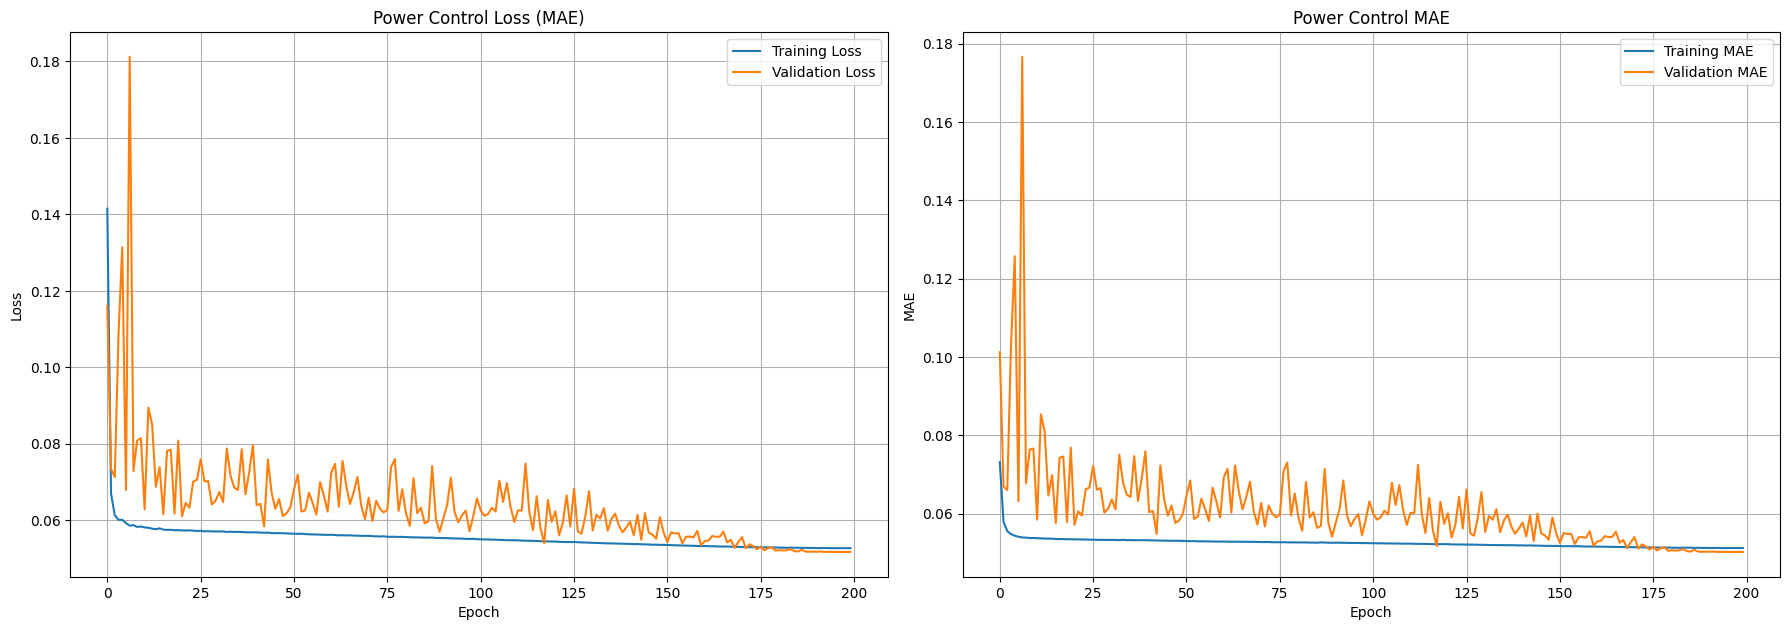

In [4]:
import matplotlib.pyplot as plt

# Plotting configuration
plt.figure(figsize=(18, 12))

# ======================
# Power Control Metrics
# ======================
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Power Control Loss (MAE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Power Control MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
import tensorflow as tf
import pandas as pd
import numpy as np
import joblib
def predict_new_data(new_beta_mk):
    # 1. Load artifacts
    model_1 = tf.keras.models.load_model('model_1.keras')
    model_1.summary()
    Beta_flat = new_beta_mk.reshape(-1, 25*6)  # Flatten to (samples, 150)
    Beta_flat = np.where(Beta_flat <= 0, 1e-30, Beta_flat)
    Beta_log = 10 * np.log10(Beta_flat)
    Beta = scaler_X.fit_transform(Beta_log)
    Beta = Beta.reshape(-1, 25, 6, 1)
    #predict 
    pred_flat = model_1.predict(Beta)
    print('pred_pc' ,pred_flat)
    # 4. Postprocess output
    y = scaler_Y.inverse_transform(pred_flat)
    pred_original = np.power(10, y / 10)   # Reverse log transform
    pred_original = np.where(pred_original < 1e-30, 0, pred_original)
    return pred_original
# Define M and K
M, K = 25, 6
# Load new beta data
#Path_Beta_predict = r"D:\OneDrive - Assuit University\My_files\Master Material\Papers\P5_Joint_Powercontrol_PilotAssignement\beta_test_1.csv"
#Beta_mk_T_Predict = pd.read_csv(Path_Beta_predict, header=None)
#print('beta',Beta_mk_T_Predict)
#new_beta = Beta_mk_T_Predict.values.reshape(-1,25,6,1)
#pc_output = predict_new_data(new_beta)

pc_output = predict_new_data(Beta_mk[0].reshape(-1,25,6,1))

#Path_eitta = r"D:\OneDrive - Assuit University\My_files\Master Material\Papers\P5_Joint_Powercontrol_PilotAssignement\Eitta_test_1.csv"
#Eitta_mk_T_Predict = pd.read_csv(Path_eitta, header=None)
#orig_eiita = Eitta_mk_T_Predict
#print('eitta_otig',orig_eiita)

#Eitta_vector = np.where(Eitta_mk[0] <= 0, 1e-30, Eitta_mk[0])
#Eitta_log = 10 * np.log10(Eitta_vector)
#Eitta = scaler_Y.fit_transform(Eitta_log)

#y = scaler_Y.inverse_transform(Eitta)
#pred_original = np.power(10, y / 10)   # Reverse log transform
#pred_original = np.where(pred_original < 1e-30, 0, pred_original)
#print('Eitta',Eitta)
#print('pred_original',pred_original)
#print('orig_eiita',orig_eiita)

#print('pred' ,pc_output)
print('y[0,:]' ,y[0])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 25, 6, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 25, 6, 64)           │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 25, 6, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 6, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 6, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 12, 6, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 460,563 (1.76 MB)

 Trainable params: 153,350 (599.02 KB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 306,701 (1.17 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
pred_pc [[0.7367429  0.91787815 0.98756677 0.7975325  0.91650796 0.9996704 ]]
y[0,:] [0.70075615 0.50706938 0.54802806 0.67527774 0.58131284 0.6856289 ]


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import joblib
def predict_new_data(new_beta_mk):
    # 1. Load artifacts
    model_1 = tf.keras.models.load_model('model_1.keras')
    model_1.summary()
    Beta_flat = new_beta_mk.reshape(-1, 25*6)  # Flatten to (samples, 150)
    Beta_flat = np.where(Beta_flat <= 0, 1e-30, Beta_flat)
    Beta_log = 10 * np.log10(Beta_flat)
    Beta = scaler_X.fit_transform(Beta_log)
    Beta = Beta.reshape(-1, 25, 6, 1)
    #predict 
    pred_flat = model_1.predict(Beta)
    print('pred_pc' ,pred_flat)
    # 4. Postprocess output
    y = scaler_Y.inverse_transform(pred_flat)
    pred_original = np.power(10, y / 10)   # Reverse log transform
    pred_original = np.where(pred_original < 1e-30, 0, pred_original)
    print('pred_original',pred_original)
    return pred_original
# Define M and K
M, K = 25, 6
# Load new beta data
Path_Beta_predict = r"D:\OneDrive - Assuit University\My_files\Master Material\Papers\P5_Joint_Powercontrol_PilotAssignement\beta_test_1.csv"
Beta_mk_T_Predict = pd.read_csv(Path_Beta_predict, header=None)
#print('beta',Beta_mk_T_Predict)
new_beta = Beta_mk_T_Predict.values.reshape(-1,25,6,1)
pc_output = predict_new_data(new_beta)

#pc_output = predict_new_data(Beta_mk[0].reshape(-1,25,6,1))

Path_eitta = r"D:\OneDrive - Assuit University\My_files\Master Material\Papers\P5_Joint_Powercontrol_PilotAssignement\Eitta_test_1.csv"
Eitta_mk_T_Predict = pd.read_csv(Path_eitta, header=None)
orig_eiita = Eitta_mk_T_Predict
print('eitta_otig',orig_eiita[0,:])

#Eitta_vector = np.where(Eitta_mk[0] <= 0, 1e-30, Eitta_mk[0])
#Eitta_log = 10 * np.log10(Eitta_vector)
#Eitta = scaler_Y.fit_transform(Eitta_log)

#y = scaler_Y.inverse_transform(Eitta)
#pred_original = np.power(10, y / 10)   # Reverse log transform
#pred_original = np.where(pred_original < 1e-30, 0, pred_original)
#print('Eitta',Eitta)
#print('pred_original',pred_original)
#print('orig_eiita',orig_eiita)

#print('pred' ,pc_output)
#print('y[0,:]' ,y[0])
